In [1]:
import os

import numpy as np
import pandas as pd

from utils.plot import plt

In [2]:
from ESG.config import RAW_DATA_DIR, PROCESSED_DATA_DIR, FIGURE_DIR, RESULT_DIR
from utils.data_porter import save_to_csv

In [3]:
esg_alter = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'a_esg_alter_events.csv'),
                        dtype={'INDICATOR_CODE': str, 'TICKER': str},
                        parse_dates=['OCCUR_DATE', 'PUBLISH_DATE'])
esg_alter = esg_alter[['SECURITY_NAME', 'TICKER', 'INDICATOR_CODE', 'POLARITY', 'ESG_TYPE', 'EVENT_TYPE',
                       'NUM_VALUE', 'PUBLISH_DATE', 'OCCUR_DATE', 'PROVINCE', 'CITY']]

esg_alter['OCCUR_YEAR'] = esg_alter['OCCUR_DATE'].apply(lambda x: x.year)
esg_alter['PUBLISH_YEAR'] = esg_alter['PUBLISH_DATE'].apply(lambda x: x.year)
esg_alter['OCCUR_YEAR_'] = esg_alter['OCCUR_YEAR'].apply(lambda x: '2010前' if x < 2010 else x)

In [4]:
indicator_codes = pd.read_excel(os.path.join(RAW_DATA_DIR, 'Indicator_codes.xlsx'), dtype={'编码': str})
esg_alter_ = pd.merge(esg_alter, indicator_codes, how='inner', left_on='INDICATOR_CODE', right_on='编码').iloc[:, :-1].sort_values(by=['INDICATOR_CODE']).reset_index(drop=True)

major_indicators = ('001001E01', '002001E01', '002005E01', '003001E01', '003001E03')
esg_alter_major = esg_alter_[esg_alter_['INDICATOR_CODE'].apply(lambda x: x in major_indicators)].copy().reset_index(drop=True)

In [5]:
yt_df = pd.DataFrame(np.zeros((12, 3)), columns=('G', 'E', 'S'), index=['2010前'] + list(range(2010, 2021)))
year_type_count = esg_alter.groupby(by=['OCCUR_YEAR_', 'ESG_TYPE']).apply(len)

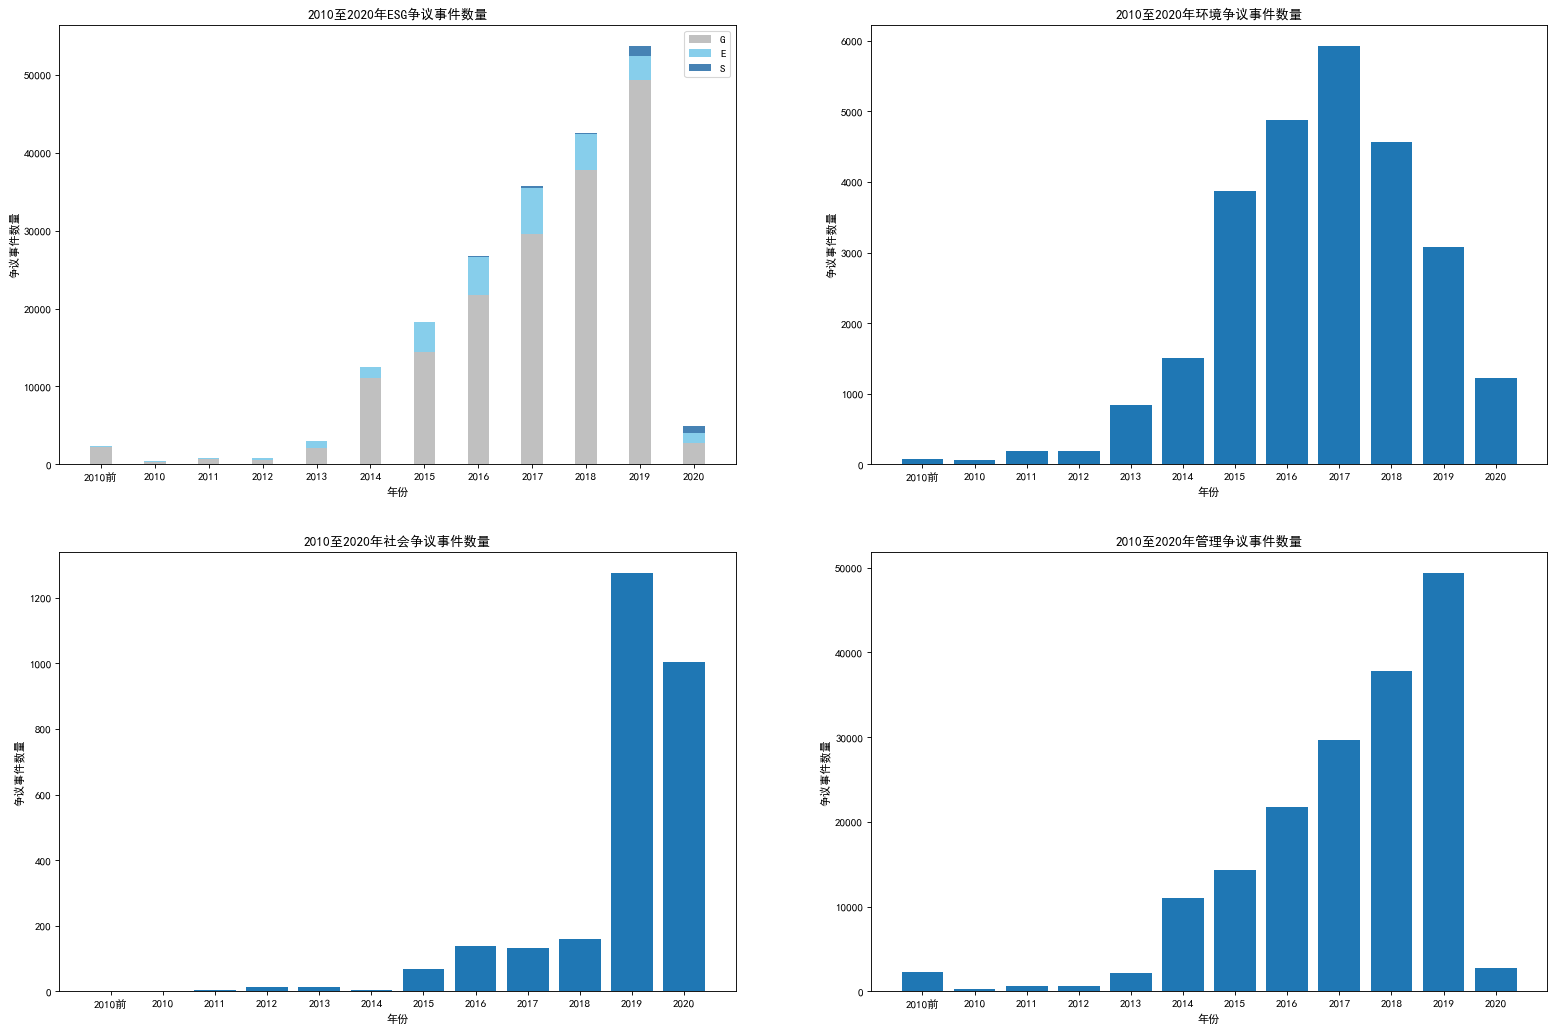

In [6]:
fig = plt.figure(figsize=(24, 16), dpi=80)

plt.subplot(221)
for i, year in enumerate(['2010前'] + list(range(2010, 2021))):
    bot = 0
    for type, color in zip(('G', 'E', 'S'), ('#C0C0C0', '#87CEEB', '#4682B4')):
        try:
            h = year_type_count[year][type]
        except KeyError:
            h = 0
        yt_df.loc[year, type] = h
        if i == 0:
            plt.bar(2 * i, h, bottom=bot, color=color, label=type)
        else:
            plt.bar(2 * i, h, bottom=bot, color=color)
        bot += h
plt.xticks(2 * np.arange(12), ['2010前'] + list(range(2010, 2021)))
plt.xlabel('年份')
plt.ylabel('争议事件数量')
plt.title('2010至2020年ESG争议事件数量')
plt.legend()

plt.subplot(222)
plt.bar(np.arange(12), yt_df.loc[:, 'E'])
plt.xticks(np.arange(12), ['2010前'] + list(range(2010, 2021)))
plt.xlabel('年份')
plt.ylabel('争议事件数量')
plt.title('2010至2020年环境争议事件数量')

plt.subplot(223)
plt.bar(np.arange(12), yt_df.loc[:, 'S'])
plt.xticks(np.arange(12), ['2010前'] + list(range(2010, 2021)))
plt.xlabel('年份')
plt.ylabel('争议事件数量')
plt.title('2010至2020年社会争议事件数量')

plt.subplot(224)
plt.bar(np.arange(12), yt_df.loc[:, 'G'])
plt.xticks(np.arange(12), ['2010前'] + list(range(2010, 2021)))
plt.xlabel('年份')
plt.ylabel('争议事件数量')
plt.title('2010至2020年管理争议事件数量')

plt.savefig(os.path.join(FIGURE_DIR, '2010-2020年ESG争议事件数量.png'))

自2010年以来，ESG争议事件数量整体逐年上涨，2020年争议事件数量大幅减少，也可能是由于疫情影响
，仍需进一步观察。在整体ESG争议事件中，管理（Government）事件占比最高；环境（Environment）
争议事件数量次之；社会（Society）争议事件数量最少。

管理争议事件在2014年呈现大幅上升后主要保持线性增长趋势；环境争议事件则在2014年大幅上升之后，
在2017年达到峰值后近年来呈现下降趋势。社会争议事件数量在2018年前增长缓慢，而在2019年大幅上升
。观察数据，可以发现社会争议事件的发布日期均在2019年后，推测可能与政策相关；然而对应列（PUBL
ISH_DATE）缺失值较多，因此结论可能并不可靠。

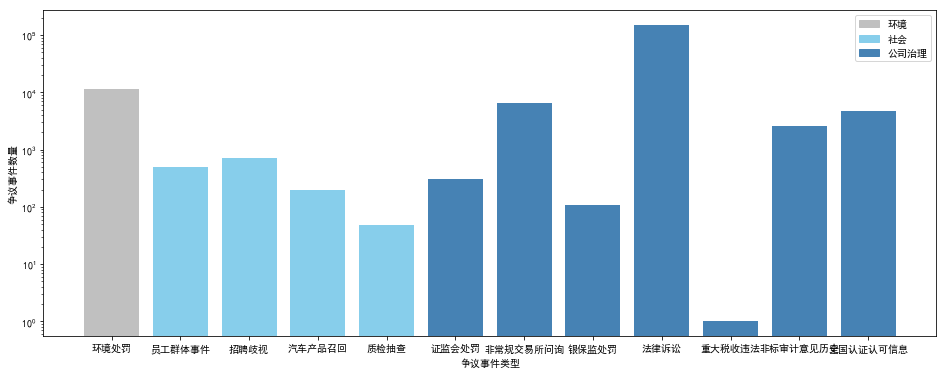

In [7]:
import matplotlib.patches as pch

plt.figure(figsize=(16, 6))
indicator_counts = esg_alter_.groupby(by=['INDICATOR_CODE']).apply(len)
xlabels = list()
colors = ('#C0C0C0', '#87CEEB', '#4682B4')
for i in range(len(indicator_counts)):
    plt.bar(i, indicator_counts[i], color=colors[int(indicator_counts.index[i][:3]) - 1])
    xlabels.append(indicator_codes.loc[indicator_codes['编码'] == indicator_counts.index[i], '三级'].values[0])
plt.xticks(np.arange(len(indicator_counts)), xlabels, rotation=0)
plt.xlabel('争议事件类型')
plt.yscale('log')
plt.ylabel('争议事件数量')
plt.legend(handles=[pch.Patch(color=c) for c in colors], labels=['环境', '社会', '公司治理'])
plt.savefig(os.path.join(FIGURE_DIR, '争议事件三级指标计数.png'))

In [8]:
major_ind_df = pd.DataFrame(np.zeros((12, 5)), 
                            columns=('环境处罚', '员工群体事件', '汽车产品召回', '证监会处罚', '银保监处罚'), 
                            index=['2010前'] + list(range(2010, 2021)))
major_ind_count = esg_alter_major.groupby(by=['OCCUR_YEAR_', '三级']).apply(len)

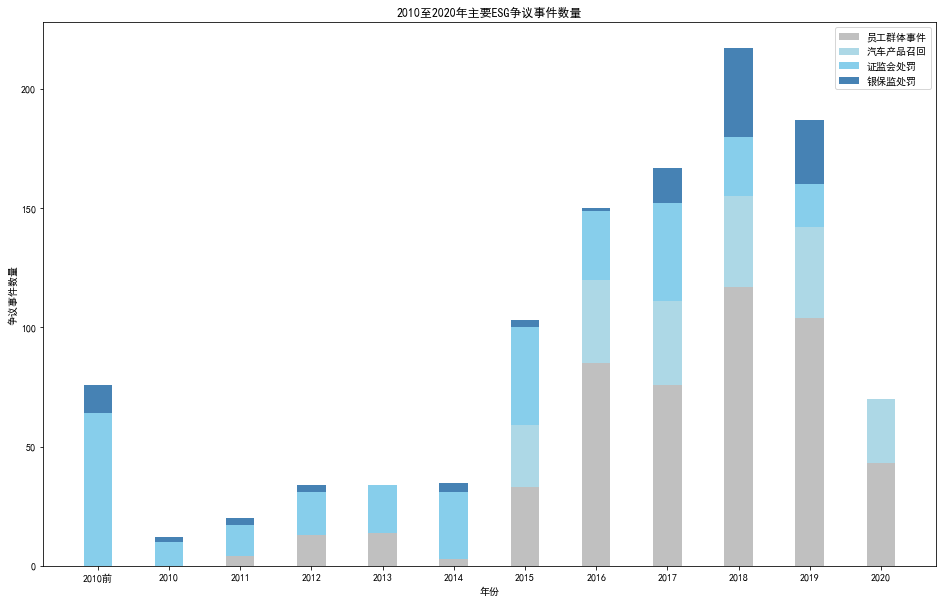

In [11]:
plt.figure(figsize=(16, 10))
for i, year in enumerate(['2010前'] + list(range(2010, 2021))):
    bot = 0
    for type, color in zip(('员工群体事件', '汽车产品召回', '证监会处罚', '银保监处罚'), 
                           ('#C0C0C0', '#ADD8E6', '#87CEEB', '#4682B4')):
        try:
            h = major_ind_count[year][type]
        except KeyError:
            h = 0
        major_ind_df.loc[year, type] = h
        if i == 0:
            plt.bar(2 * i, h, bottom=bot, color=color, label=type)
        else:
            plt.bar(2 * i, h, bottom=bot, color=color)
        bot += h
plt.xticks(2 * np.arange(12), ['2010前'] + list(range(2010, 2021)))
plt.xlabel('年份')
plt.ylabel('争议事件数量')
plt.title('2010至2020年主要ESG争议事件数量')
plt.legend()

In [10]:
event_num = esg_alter.loc[~esg_alter['EVENT_TYPE'].isna(), :].groupby(by=['EVENT_TYPE']).apply(len).sort_values(ascending=False)
top_event_types = event_num.index[:20]
# esg_alter['top_event_types'] = esg_alter['EVENT']

In [ ]:
pd.unique(esg_alter[esg_alter['POLARITY'] == 'POSITIVE']['EVENT_TYPE'])

In [ ]:
from functools import reduce

def split(event_type):
    res = list()
    event_ = event_type.split(',')
    for e in event_:
        res.extend(e.split('/'))
    return res
    
def split_event_type(type):
    return reduce(lambda x, y: set(x).union(set(y)), 
           esg_alter[esg_alter['ESG_TYPE']==type].loc[~esg_alter['EVENT_TYPE'].isna(), 
                                                      'EVENT_TYPE'].apply(split))

In [ ]:
event_types = dict()
event_types['E'] = split_event_type('E')
event_types['S'] = split_event_type('S')
event_types['G'] = split_event_type('G')

In [16]:
def count_event_type(type):
    ec_df = pd.DataFrame()
    type_df = esg_alter.loc[esg_alter['ESG_TYPE']==type, 'EVENT_TYPE'].loc[~esg_alter['EVENT_TYPE'].isna()]
    ec_df['EVENT_TYPE'] = list(event_types[type])
    ec_df['COUNTS'] = ec_df['EVENT_TYPE'].apply(lambda t: type_df.apply(lambda x: t in x).sum())
    return ec_df

In [17]:
e_event_count_df = count_event_type('E').sort_values(by=['COUNTS'], inplace=False).reset_index(drop=True)
s_event_count_df = count_event_type('S').sort_values(by=['COUNTS'], inplace=False).reset_index(drop=True)
g_event_count_df = count_event_type('G').sort_values(by=['COUNTS'], inplace=False).reset_index(drop=True)

观察

Text(0.5, 1.0, '环境争议事件各类型累计')

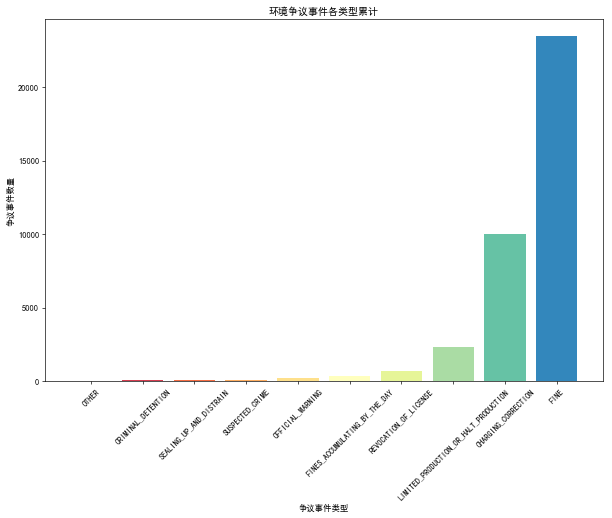

In [18]:
plt.figure(figsize=(12, 8), dpi=60)
colors = [plt.cm.Spectral(i/10) for i in range(10)]
plt.bar(np.arange(10), e_event_count_df['COUNTS'], color=colors)
plt.xticks(np.arange(10), [i[19:] for i in e_event_count_df['EVENT_TYPE']], rotation=45)
plt.xlabel('争议事件类型')
plt.ylabel('争议事件数量')
plt.title('环境争议事件各类型累计')

In [19]:
e_event_count_df['COUNTS']

0       56
1       81
2      116
3      120
4      218
5      358
6      714
7     2376
8    10042
9    23450
Name: COUNTS, dtype: int64

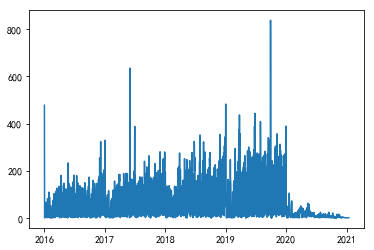

In [20]:
plt.plot(esg_alter[esg_alter['OCCUR_DATE'] >= '2016-01-01'].groupby(by=['OCCUR_DATE']).apply(len))
# esg_alter.groupby(by=['OCCUR_DATE', 'ESG_TYPE']).apply(len)